In [20]:
import numpy as np
import itertools
%matplotlib inline
from matplotlib import pyplot as plt
from functools import partial

Testing the following equations for $\Delta(w,u)=f(w+u)-f(w)$
$$
\mathbb{E}\Delta(w,u)=f'_i\mathbb{E}u+\frac{1}{2}f''_{ii}\mathbb{V}ar u+\frac{1}{2}\mathbb{E}u^Tf''_{ij}\mathbb{E}u+\mathcal{O}(\alpha^3)
$$

$$
\mathbb{E}\Delta(w,u)=(f'_i)^2\mathbb{V}ar u+(f'_{i}\mathbb{E} u)^2+\mathcal{O}(\alpha^3)
$$

Will use Gaussian input $\mathbb{R}^d\ni x\sim N(\mu_x,\sigma_x^2 I)$, one hidden layer with $\sigma(x)=\frac{1}{1+e^{-x}}$ and Gaussian weights $w\in\mathbb{R}^d$ with $w\sim N(\mu_w,\sigma_w^2 I)$

The distribution of crashes of inputs is Bernoulli with parameter $p$.

In [42]:
mu_x = 1
sigma_x = 0.2
mu_w = 0.05
sigma_w = 0.1
d = 10
p = 0.1

In [43]:
# generating x and w
x = np.random.randn(d, 1) * sigma_x + mu_x
w = np.random.randn(d, 1) * sigma_w + mu_w

In [44]:
def sigma(x):
    """ Activation fcn """
    return 1. / (1 + np.exp(-x))

def sigma_dot(x):
    """ Derivative of sigma """
    return sigma(x) * (1. - sigma(x))

def sigma_ddot(x):
    """ Double derivative of sigma """
    return sigma(x) * (1. - sigma(x)) * (1. - 2 * sigma(x))

In [45]:
def compute_mean_and_var_bernoulli_twosided(fcn, p, threshold = lambda x : True):
    """ Compute expectation and variance of fcn given Bernoulli crashes w.p. p
        Two sided: w.p. p/2 +x, w.p. p/2 -x
    """
    # all combinations
    combinations = list(itertools.product([0, 1, 2], repeat=len(x)))
    
    # resulting expectation of fcn
    result_f = 0.
    
    # resulting expectation of fcn^2
    result_f_sq = 0.
    
    # number of entries in x
    n = len(x)

    # all probs
    probs = 0
    
    for c in combinations:
        # crashing inputs
        x1 = np.multiply(x.reshape(-1), c)
        
        # number of crashes
        k = len(c) - np.sum(np.array(c) != 1)
        
        # probability of this event
        prob = p ** k * (1 - p) ** (n - k) / 2
        
        # how much vector is changed in norm?
        alpha = np.linalg.norm(x.reshape(-1) - x1) / np.linalg.norm(x)
        
        # not suitable -> skipping this crash
        if not threshold(x1):
            continue
        
        # adding to fracs distribution
        fracs.append(alpha)
        
        #print(n, k, prob, fcn(x1))
        
        # computing expectation
        result_f += fcn(x1) * prob
        result_f_sq += fcn(x1) ** 2 * prob
        
        probs += prob
        
    result_f /= probs
    result_f_sq /= probs
        
    return result_f, result_f_sq - result_f ** 2

In [46]:
def compute_mean_and_var_bernoulli(fcn, p, threshold = lambda x : True):
    """ Compute expectation and variance of fcn given Bernoulli crashes w.p. p
        Two sided: w.p. p/2 +x, w.p. p/2 -x
    """
    # all combinations
    combinations = list(itertools.product([0, 1], repeat=len(x)))
    
    # resulting expectation of fcn
    result_f = 0.
    
    # resulting expectation of fcn^2
    result_f_sq = 0.
    
    # number of entries in x
    n = len(x)

    # all probs
    probs = 0
    
    for c in combinations:
        # crashing inputs
        x1 = np.multiply(x.reshape(-1), c)
        
        # number of crashes
        k = len(c) - np.sum(c)
        
        # probability of this event
        prob = p ** k * (1 - p) ** (n - k)
        
        # how much vector is changed in norm?
        alpha = np.linalg.norm(x.reshape(-1) - x1) / np.linalg.norm(x)
        
        # not suitable -> skipping this crash
        if not threshold(x1):
            continue
        
        # adding to fracs distribution
        fracs.append(alpha)
        
        #print(n, k, prob, fcn(x1))
        
        # computing expectation
        result_f += fcn(x1) * prob
        result_f_sq += fcn(x1) ** 2 * prob
        
        probs += prob
        
    result_f /= probs
    result_f_sq /= probs
        
    return result_f, result_f_sq - result_f ** 2

In [47]:
def nn(x):
    """ Neural network at pt x """
    return np.mean(sigma(x.T @ w))

In [48]:
z = np.mean(x.T @ w)
def delta(x1):
    """ Error delta(input crash) """
    return nn(x1) - nn(x)

In [49]:
z, sigma(z)

(0.4967277342115286, 0.621690029006334)

In [50]:
def experiment(distribution):
    """ Calculate experiment for distribution """
    # fractions of change in norm
    global fracs
    fracs = []

    # Delta (experimental)
    EDelta, VarDelta = distribution(delta)

    # plotting alphas
    plt.figure()
    plt.hist(fracs)
    plt.show()

    # Error (experimental)
    Eu, Varu = distribution(lambda z : np.array(z) - x.reshape(-1))

    print(Eu, Varu)
    
    # derivatives
    f_i = sigma_dot(z) * w
    f_ij = sigma_ddot(z) * w @ w.T
    f_ii = f_ij.diagonal()

    EDelta_theory = (np.dot(f_i.T, Eu) + 0.5 * np.dot(f_ii, Varu) + 0.5 * Eu.T @ f_ij @ Eu)[0]
    VarDelta_theory = (np.dot(f_i.T ** 2, Varu) + np.dot(f_i.T, Eu) ** 2)[0]
    
    print(EDelta, EDelta_theory)
    print(VarDelta, VarDelta_theory)

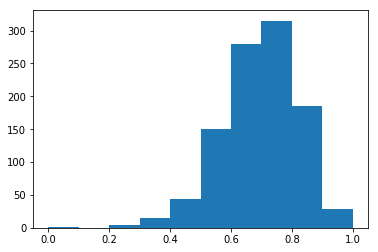

[-0.0977315  -0.07633141 -0.10817022 -0.07276091 -0.10588762 -0.06602459
 -0.09390895 -0.07824882 -0.10254912 -0.0768122 ] [0.08596301 0.05243836 0.10530718 0.04764735 0.10090969 0.03923322
 0.07937002 0.05510591 0.09464689 0.05310103]
-0.01194531601744227 -0.011979223244082966
0.0004534249323901253 0.0005732559433800351


In [51]:
experiment(partial(compute_mean_and_var_bernoulli, threshold = lambda x : True, p = p))

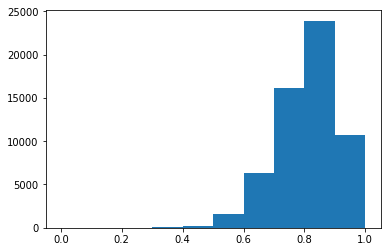

[ 3.45865774e-17 -2.62568258e-18 -1.24040867e-17  1.90135635e-18
 -2.53514180e-18 -9.05407785e-20  3.62163114e-19  0.00000000e+00
  0.00000000e+00  0.00000000e+00] [0.90487376 0.55198274 1.10849661 0.50155105 1.06220731 0.41298131
 0.83547391 0.58006217 0.99628305 0.55895817]
-0.002302491527228326 -0.002378838260710424
0.004471956981356697 0.00459760451205248


In [52]:
experiment(partial(compute_mean_and_var_bernoulli_twosided, threshold = lambda x : True, p = p))

Is it true that $P\{u|\|u\|\geq\alpha \|w\|\}$ is small?

In [68]:
def compute_prob_delta_small(p, alpha_0 = 0.5):
    """ Compute expectation and variance of fcn given Bernoulli crashes w.p. p
        Two sided: w.p. p/2 +x, w.p. p/2 -x
    """
    # all combinations
    combinations = list(itertools.product([0, 1], repeat=len(x)))
    
    # number of entries in x
    n = len(x)

    # all probs
    probs = 0
    
    probs_small = 0
    deltas = {n_: [] for n_ in range(len(x) + 1)}
    
    for c in combinations:
        # crashing inputs
        x1 = np.multiply(x.reshape(-1), c)
        
        # number of crashes
        k = len(c) - np.sum(c)
        
        # probability of this event
        prob = p ** k * (1 - p) ** (n - k)
        
        # how much vector is changed in norm?
        alpha = np.linalg.norm(x.reshape(-1) - x1) ** 2 / np.linalg.norm(x) ** 2
        
        deltas[k].append(alpha)
        
        probs += prob
        
        if alpha <= alpha_0:
            probs_small += prob
    return (probs - probs_small) / probs, deltas

In [69]:
p, deltas = compute_prob_delta_small(p, 0.5)

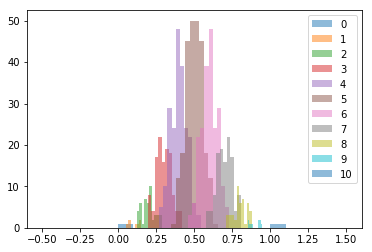

In [70]:
plt.figure()
for k in sorted(deltas.keys()):
    h = deltas[k]
    plt.hist(h, alpha = 0.5, label = '%d' % k)
plt.legend()
plt.show()

Answer: kinda for $\leq 3$ crashes $\alpha\leq 0.5$

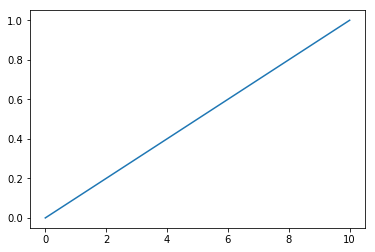

In [72]:
# Plotting squared norm change with growing f
plt.plot([np.mean(deltas[k]) for k in sorted(deltas.keys())])